# Objective:
### 1) To find out significant variables required for the prediciton of house prices
### 2) Build a model using the variables

In [35]:
# Importing the libraries
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings("ignore")
import statsmodels.api as sm

In [36]:
# Reading and viewing the data
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
# Total number of columns are 81
# Checking the value counts in the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [38]:
#  Form the data dictionary, the column id is irrelevant for prediction
data.drop("Id",inplace=True,axis=1)

In [39]:
# Some of the columns have many missing values which will not help in building the model
# Deleting the columns havving more than 30% of missing values
remo_col=[]
for col in data.columns:
    if data[col].isna().sum() > 0.7* len(data):
        data.drop(col,inplace=True,axis=1)
        remo_col.append(col)
print("The number of columns removed are: ",len(remo_col))
print(remo_col)

The number of columns removed are:  4
['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [40]:
# Sorting the data based on data type
cat_data=data.loc[:,(data.dtypes == object).values]
num_data= data.loc[:,~(data.dtypes == object).values]



In [41]:
# Sorting the columns based on datatypes
num_columns = list(num_data.columns)
cat_columns = list(cat_data.columns)

In [42]:
# Removing columns having a single value occuring more than 90% of times
single_rep_col = []
for col in cat_data:
    if (cat_data[col].value_counts(normalize=True).values)[0]>=0.9:
        single_rep_col.append(col)
        data.drop(col,inplace=True,axis=1)
print("The number of columns removed are: ",len(single_rep_col))
print(single_rep_col)

The number of columns removed are:  13
['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive']


In [43]:
# Checking columns having missing values in data
mis_col=[]
for col in data.columns:
    if not(data[col].isna().sum() == 0):
        mis_col.append(col)
print("The number of columns having missing columns: ",len(mis_col))
print(mis_col)


The number of columns having missing columns:  11
['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish']


In [44]:
#  Misssing value imputation
#  Filling the missing values with median if the column is numeric and with mode if the column is categorical
for miscol in mis_col:
    if miscol in num_data.columns:
        data[miscol].fillna(data[miscol].median(),inplace=True)
    elif miscol in cat_data.columns:
        data[miscol].fillna(data[miscol].value_counts().values[0],inplace=True)


In [45]:
#  Checking the df after missing value imputation
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 63 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   Condition1     1460 non-null   object 
 9   BldgType       1460 non-null   object 
 10  HouseStyle     1460 non-null   object 
 11  OverallQual    1460 non-null   int64  
 12  OverallCond    1460 non-null   int64  
 13  YearBuilt      1460 non-null   int64  
 14  YearRemodAdd   1460 non-null   int64  
 15  RoofStyle      1460 non-null   object 
 16  Exterior1st    1460 non-null   object 
 17  Exterior2nd    1460 non-null   object 
 18  MasVnrTy

In [46]:
#  Dummy encoding for categorical variables
data_with_dummies = pd.get_dummies(data,drop_first=True)

<AxesSubplot:>

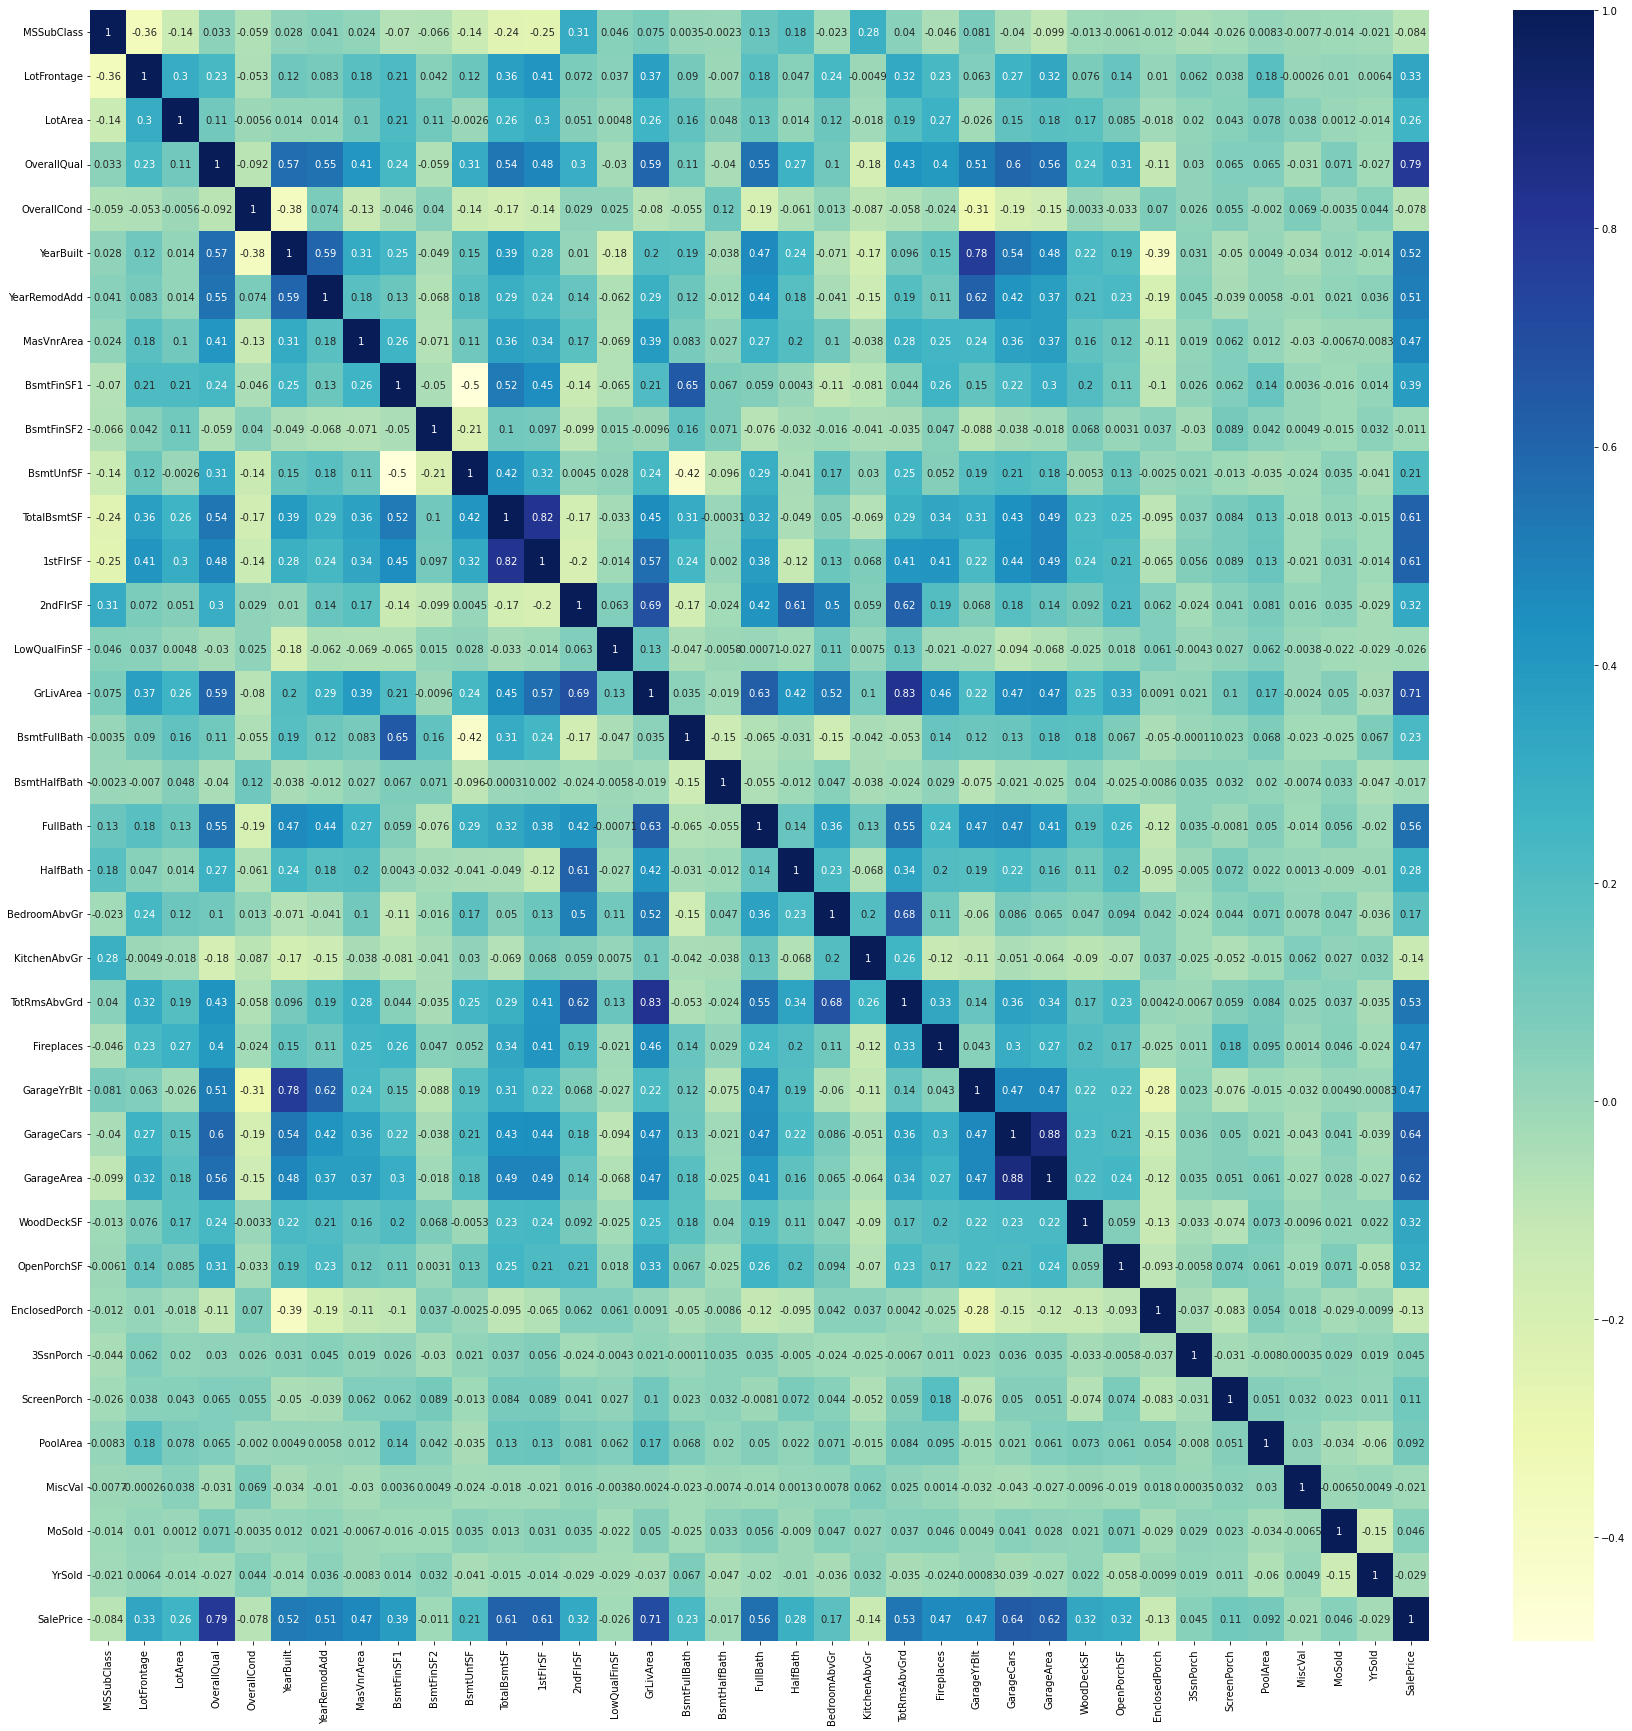

In [47]:
# Plotting corelation matrix between variables - bivariate analysis
corr_mat = data.corr()
corr_mat_with_dummies = data_with_dummies.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr_mat,annot=True,cmap="YlGnBu")

In [48]:
#  Listing the top corelated variables
top_cat=list(corr_mat_with_dummies.sort_values(by="SalePrice")["SalePrice"].head().index)
top_cat = [x.split("_")[0] for x in top_cat]
print(top_cat)

['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageFinish', 'MasVnrType']


In [49]:
top_num=list(corr_mat_with_dummies.sort_values(by="SalePrice",ascending=False)["SalePrice"].head(6).index)
top_num.remove("SalePrice")
print(top_num)

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']


In [50]:
#  From the heatmap it can be seen that from the list of features the top correlated variables with SalePrice are
#  1) OverallQual
#  2) GrLivArea
#  3) GarageCars
#  4) GarageArea
#  5) TotalBsmtSF
#  6) ExterQual_TA - ExterQual
#  7) KitchenQual_TA - KitachenQual
#  8) BsmtQual_TA -  BsmtQual
#  9) GarageFinish_Unf - GarageFinish
#  10) MasVnrType_None - MasVnrType

In [51]:
# Class for EDA
class EDA:
    def __init__(self,num_feat,cat_feat): # Instance attributes
        self.num = num_feat
        self.cat = cat_feat

    def dist_plot(self,data): # method for dist plot
        for i in self.num:
            plt.figure(figsize=(15,10))
            sns.distplot(data[i],bins=50)
            plt.xlabel(i,fontsize=12)
            plt.ylabel("Density",fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.show()

    def bar_plot(self,data):
        for i in self.cat:
            plt.figure(figsize=(15,10))
            axes = sns.barplot(x=i,y="SalePrice",data=data,estimator=np.median,ci=None)
            plt.xlabel(i,fontsize=12)
            plt.ylabel("Mean of SalePrice",fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.show()

    def scatter_plot(self,data):
        for i in self.num:
            plt.figure(figsize=(15,10))
            plt.scatter(data[i],data["SalePrice"])
            plt.xlabel(i,fontsize=12)
            plt.ylabel("SalePrice",fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.show()
        


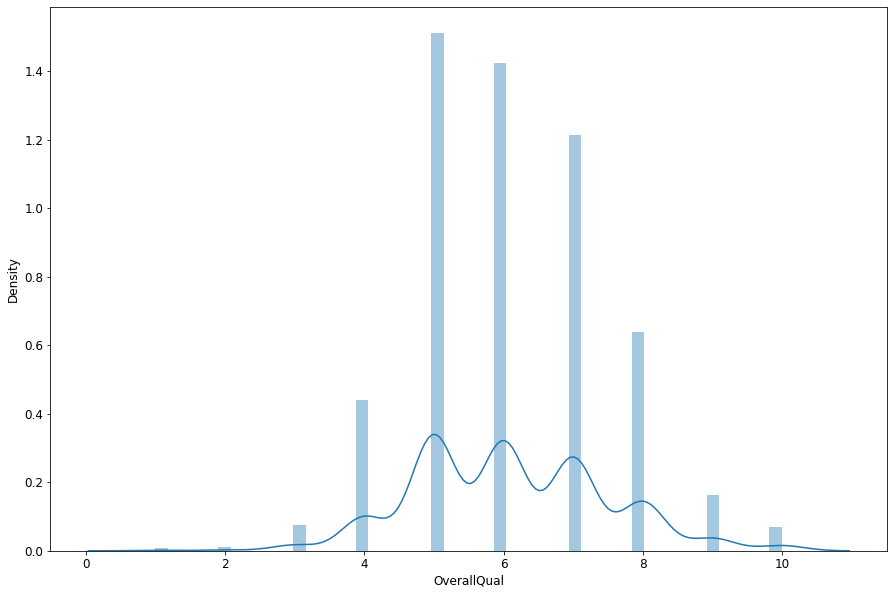

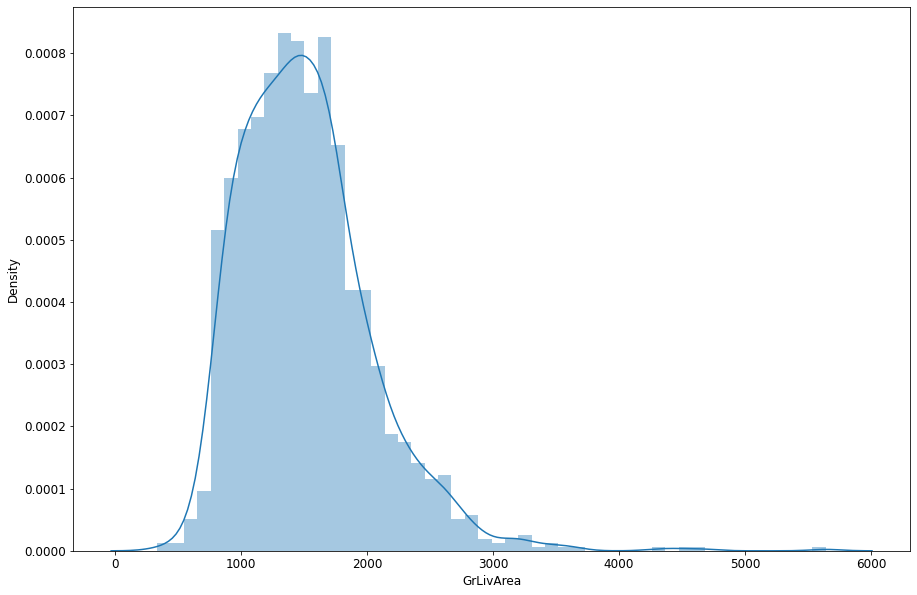

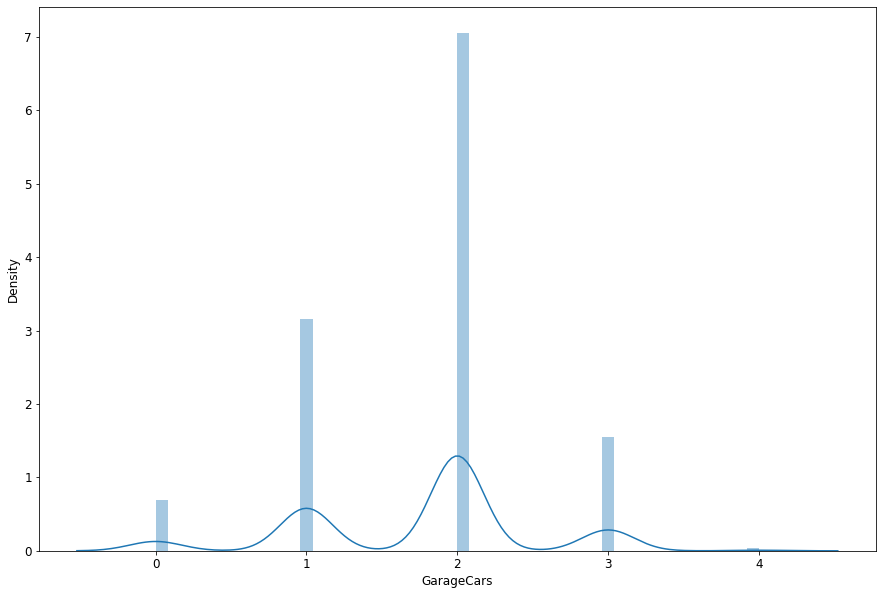

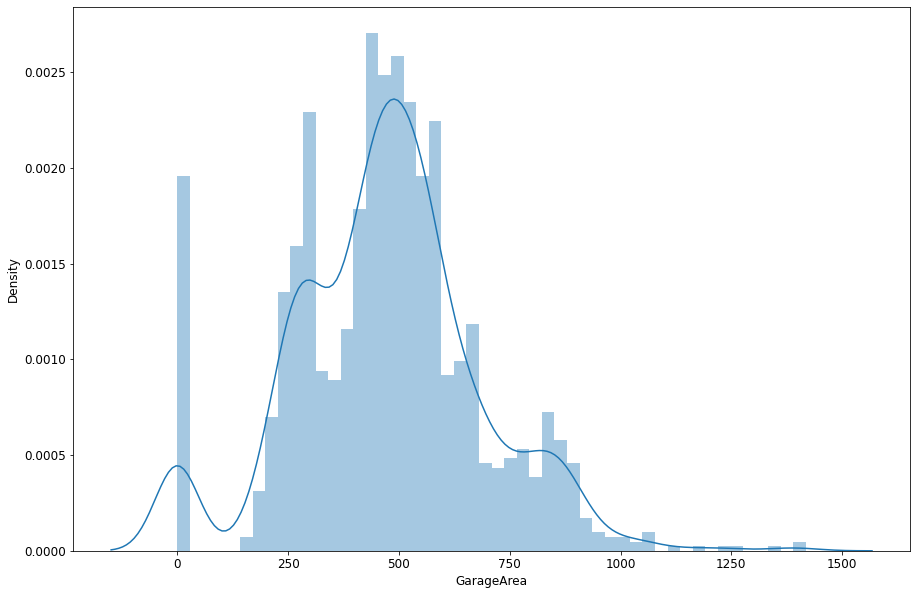

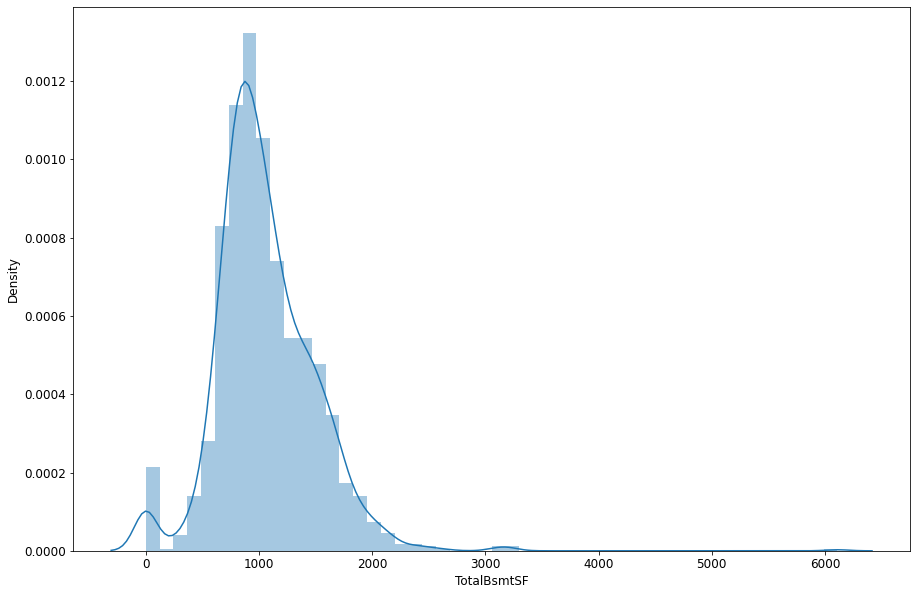

In [52]:
# Performing EDA for top 10 variables
# Univariate analysis
eda = EDA(top_num,top_cat)
eda.dist_plot(data)

In [53]:
# From the plots we can infer that 
# Overall quality of most of the houses is > 5
# GrLivArea is following near normal distribution
# Most of the houses have 2 Garage cars
# For most of the houses the garage area is 500
# For most of the houses the total bsmt sft is 1000

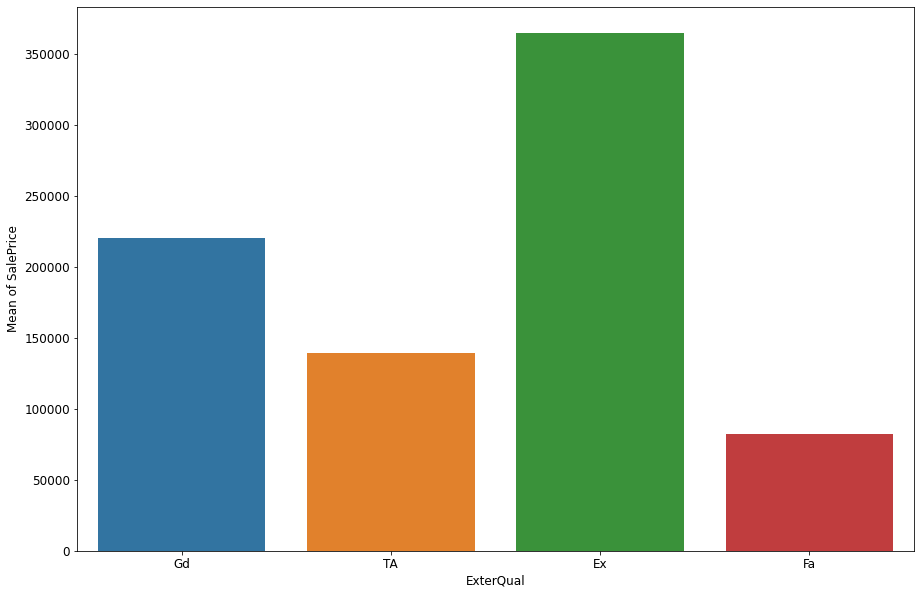

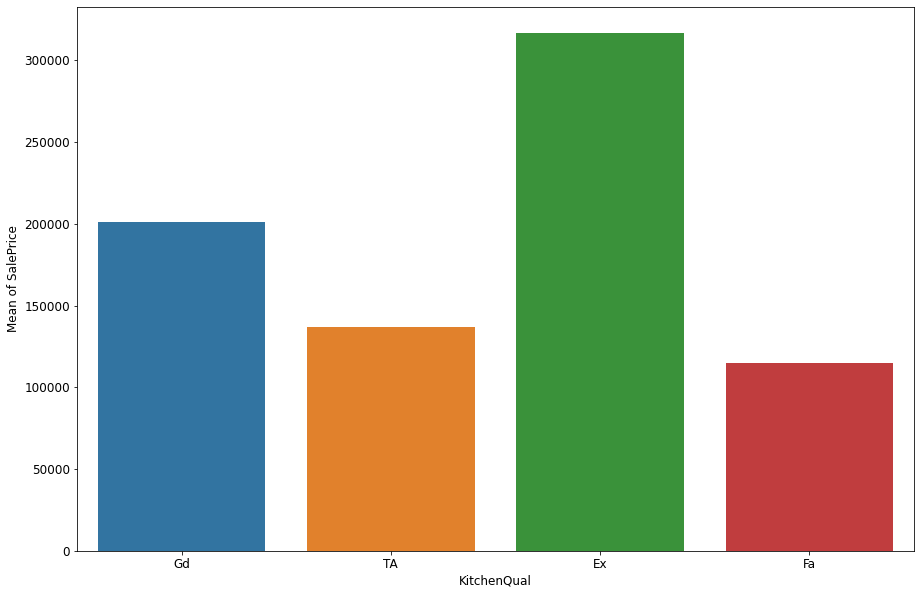

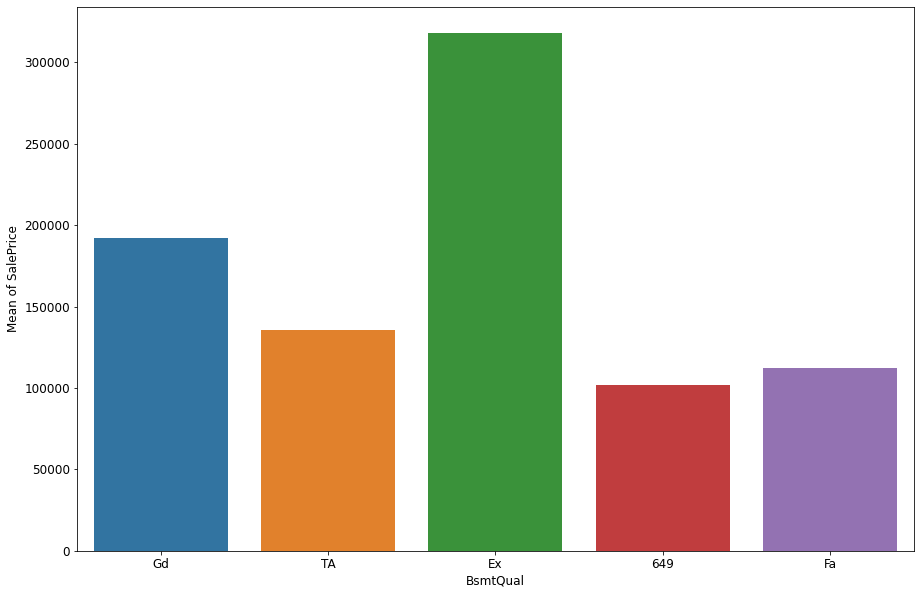

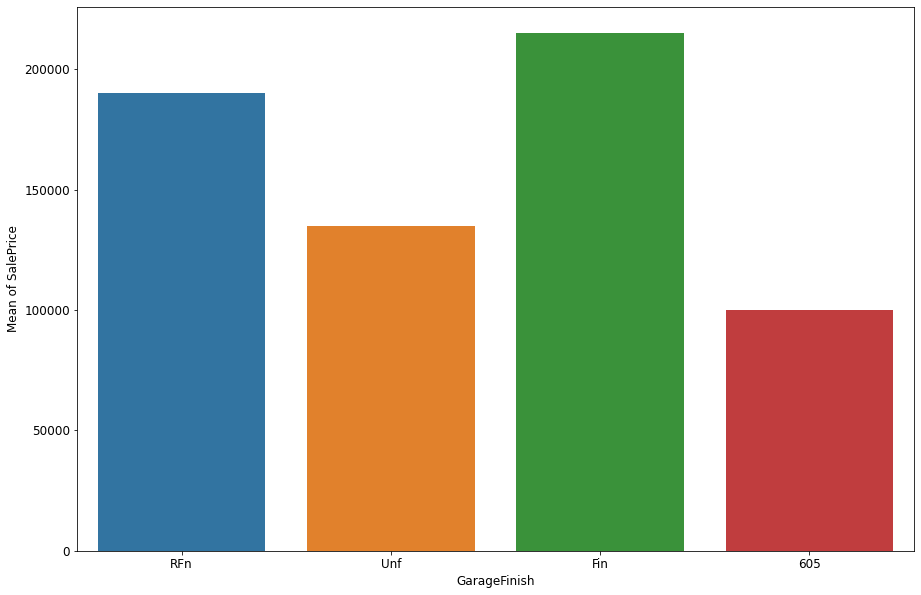

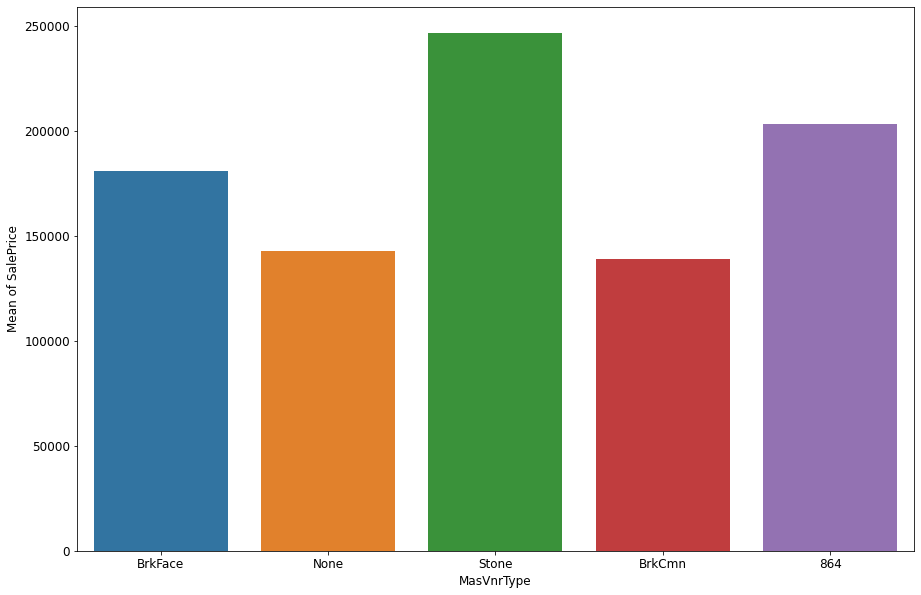

In [54]:
# Bivariate analysis
eda.bar_plot(data)

In [55]:
#  From the bar plots we can infer that
#  If the external quality,kitchen quality and basement quality is excellent the avg sale price is more
#  The saleprice is more for finished garages
#  If the masonary veener type is stone the sale price is more

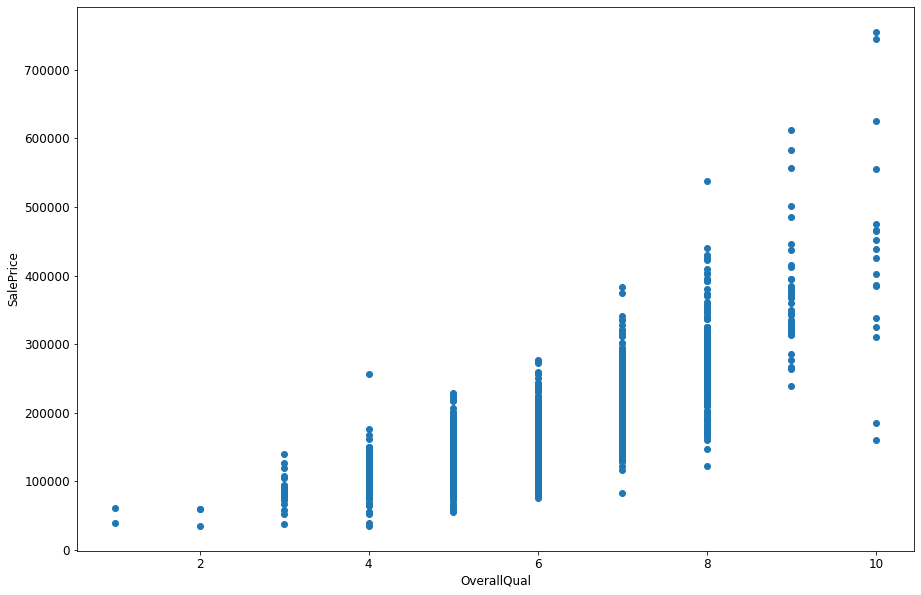

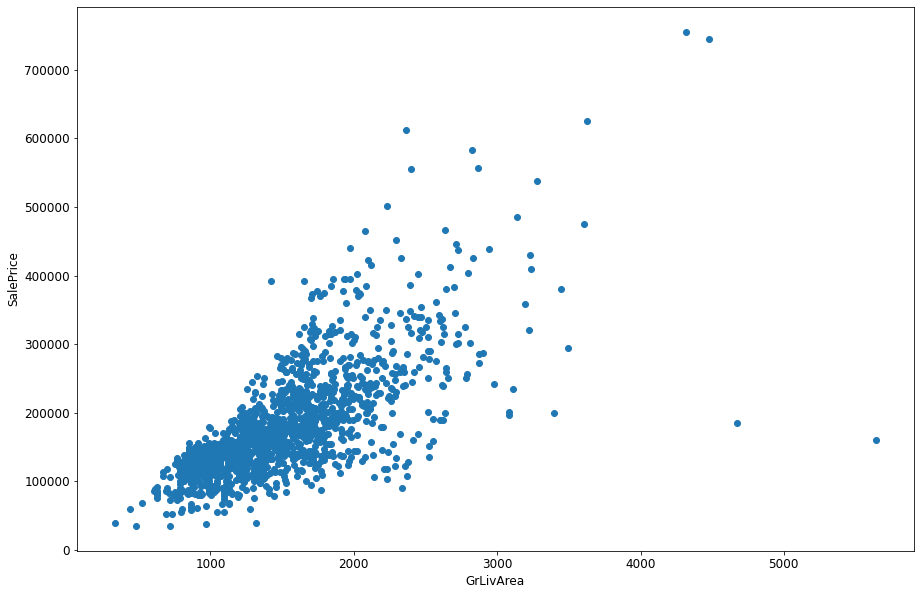

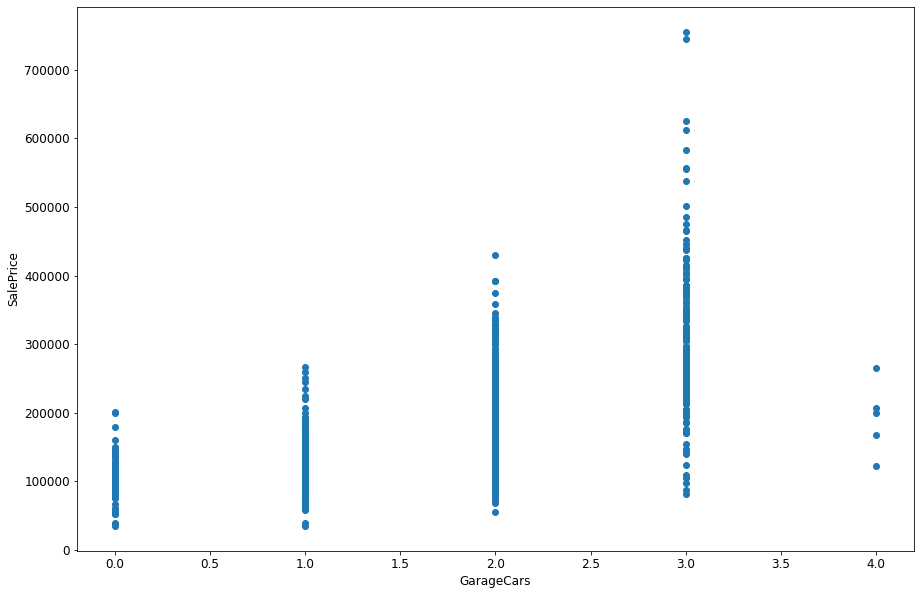

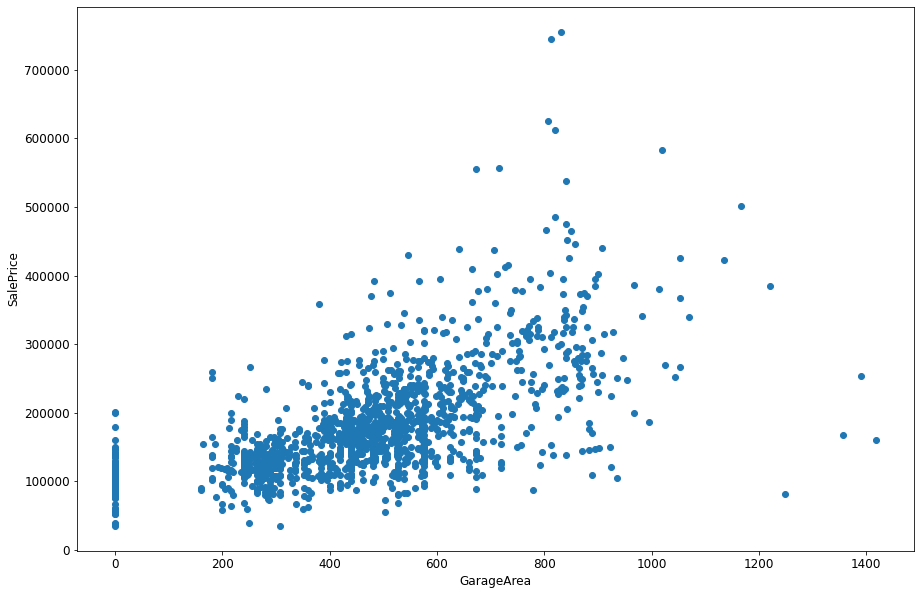

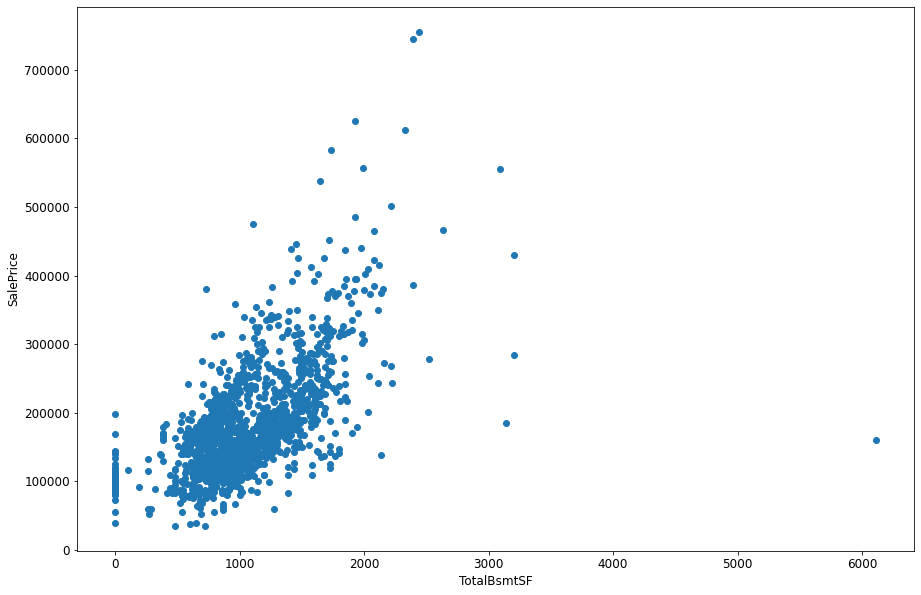

In [56]:
# Scatter plot between numerical variables
eda.scatter_plot(data)

In [57]:
# From the scatter plot we can see linear relationship between our selected variables and SalePrice

In [58]:
# Model building
data = data_with_dummies # replacing the original data with the data with dummy encoding 

In [59]:
# Creating a list for storing all models
all_models=[]

In [60]:
# Class for model building
class model_build:
    
    def __init__(self,input_data,feat,target): # Instance attributes
        self.data = input_data
        self.X = feat
        self.y = target
    
    def split_data(self,test_ratio): # Method for splitting the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data[self.X], self.data[self.y], test_size=test_ratio, random_state=42)
    
    def perform_scaling(self): # Method for sclaing the data using Min max scaler
        self.scaler = MinMaxScaler()
        self.X_train = pd.DataFrame(self.scaler.fit_transform(self.X_train),columns=self.X_train.columns)
        self.X_test = pd.DataFrame(self.scaler.transform(self.X_test),columns=self.X_test.columns)

    def perform_rfe(self,n_sel_feat): # Method for performing RFE
        self.rfe_model = LinearRegression()
        self.rfe = RFE(self.rfe_model,n_sel_feat)
        self.rfe.fit(self.X_train,self.y_train)
        self.X_train = self.X_train.loc[:,self.rfe.get_support()]
        self.X_test = self.X_test.loc[:,self.rfe.get_support()]
    
    def perform_ridge(self,grid): # Method for training ridge model
        self.ridgemodel = Ridge()
        self.ridge = GridSearchCV(self.ridgemodel,param_grid=grid,scoring="r2",cv=5)
        self.ridge.fit(self.X_train,self.y_train)
        print("The best value of alpha found is : ",self.ridge.best_params_)
        print("The R2 on the train set is : ",self.ridge.best_score_)
        self.ridge_trscore = self.ridge.best_score_
        self.ridge_tescore = r2_score(self.ridge.predict(self.X_test),self.y_test)
        print("The R2 on the test set is : ",self.ridge_tescore)

    def perform_lasso(self,grid): # Method for training lasso model
        self.lassomodel = Lasso()
        self.lasso = GridSearchCV(self.lassomodel,param_grid=grid,scoring="r2",cv=5)
        self.lasso.fit(self.X_train,self.y_train)
        self.lassoselfeat = list(self.X_train.loc[:,np.array(self.lasso.best_estimator_.coef_,dtype=bool)].columns)
        print("The best value of alpha found is : ",self.lasso.best_params_)
        print("The R2 on the train set is : ",self.lasso.best_score_)
        self.lasso_trscore = self.lasso.best_score_
        self.lasso_tescore = r2_score(self.lasso.predict(self.X_test),self.y_test)
        print("The R2 on the test set is : ",self.lasso_tescore)

    
    def calc_vif(self): # Method to calculate VIF
        sel_feat = list(self.X_train.columns)
        if len(sel_feat)<=1:
            print("Cannot calculate VIF as only one feature is present")
        else:
            self.vif_data = pd.DataFrame()
            self.vif_data["Features"]=sel_feat
            self.vif_data["VIF_values"] =  [variance_inflation_factor(self.X_train[sel_feat].values, i) for i in range(len(sel_feat))]
            self.vif_data = self.vif_data.sort_values(by="VIF_values",ascending=False)
            print(self.vif_data)

    def calc_sig(self): # Method to train the model using stats mod library
        stats_X_train = self.X_train.copy()
        stats_X_train["cnst"] = 1
        model = sm.OLS(self.y_train.values.reshape(-1,1),stats_X_train)
        trained_model = model.fit()
        print(trained_model.summary())

def train_models(data,X,y,n_sel,userfe,grid_search): # function for training the models
    
    model_obj = model_build(data,X,y)
    print("Splitting the data")
    model_obj.split_data(0.3)
    print("Scaling the train set using min-max scaler")
    model_obj.perform_scaling()
    if userfe:
        print("Selecting top " + str(n_sel) + " using RFE")
        model_obj.perform_rfe(n_sel)
    print("Training lasso model")
    model_obj.perform_lasso(grid_search)
    print("Training ridge model")
    model_obj.perform_ridge(grid_search)
    print("Calculating significance of coefficients")
    model_obj.calc_sig()
    print("Calculating VIF")
    model_obj.calc_vif()

    return model_obj


In [61]:
#  1) Training the model using top 20 features
X = list(data.columns)
X.remove("SalePrice")
y = ["SalePrice"]
grid = {"alpha" : [int(2**i) for i in range(0,9)]}
all_models.append(train_models(data,X,y,20,1,grid))


Splitting the data
Scaling the train set using min-max scaler
Selecting top 20 using RFE
Training lasso model
The best value of alpha found is :  {'alpha': 128}
The R2 on the train set is :  0.7779078573242281
The R2 on the test set is :  0.7824770553478887
Training ridge model
The best value of alpha found is :  {'alpha': 2}
The R2 on the train set is :  0.7864696581778432
The R2 on the test set is :  0.7734390598195512
Calculating significance of coefficients
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     240.3
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:45:44   Log-Likelihood:                -12058.
No. Observations:                1022   AIC:                

In [62]:
# As the p value for HeatingQC_Po is high dropping it
X= list(all_models[-1].X_train.columns) # Collecting previous trained model selected values
X.remove("HeatingQC_Po")
all_models.append(train_models(data,X,y,15,0,grid))

Splitting the data
Scaling the train set using min-max scaler
Training lasso model
The best value of alpha found is :  {'alpha': 128}
The R2 on the train set is :  0.7779078573242281
The R2 on the test set is :  0.7824770553478887
Training ridge model
The best value of alpha found is :  {'alpha': 2}
The R2 on the train set is :  0.786480070959113
The R2 on the test set is :  0.7735443774186472
Calculating significance of coefficients
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     253.1
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:45:45   Log-Likelihood:                -12059.
No. Observations:                1022   AIC:                         2.416e+04
Df Residu

In [63]:
# As the VIF for TotalBsmtSF is high not considering it for further models
X= list(all_models[-1].X_train.columns) # Collecting previous trained model selected values
X.remove("TotalBsmtSF")
all_models.append(train_models(data,X,y,15,0,grid))


Splitting the data
Scaling the train set using min-max scaler
Training lasso model
The best value of alpha found is :  {'alpha': 128}
The R2 on the train set is :  0.7827200064498336
The R2 on the test set is :  0.7823644266694658
Training ridge model
The best value of alpha found is :  {'alpha': 2}
The R2 on the train set is :  0.7894274791793586
The R2 on the test set is :  0.7701384019227158
Calculating significance of coefficients
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     266.9
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:45:46   Log-Likelihood:                -12060.
No. Observations:                1022   AIC:                         2.416e+04
Df Resid

In [64]:
# As the VIF for GarageType_2Types is high not considering it for further models
X= list(all_models[-1].X_train.columns) # Collecting previous trained model selected values
X.remove("GarageType_2Types")
all_models.append(train_models(data,X,y,15,0,grid))

Splitting the data
Scaling the train set using min-max scaler
Training lasso model
The best value of alpha found is :  {'alpha': 128}
The R2 on the train set is :  0.7827956685225865
The R2 on the test set is :  0.7823644266694658
Training ridge model
The best value of alpha found is :  {'alpha': 2}
The R2 on the train set is :  0.788828716328667
The R2 on the test set is :  0.7703497460856263
Calculating significance of coefficients
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     281.7
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:45:47   Log-Likelihood:                -12061.
No. Observations:                1022   AIC:                         2.416e+04
Df Residu

In [65]:
# As the VIF for OverallQual is high not considering it for further models
X= list(all_models[-1].X_train.columns) # Collecting previous trained model selected values
X.remove("OverallQual")
all_models.append(train_models(data,X,y,15,0,grid))

Splitting the data
Scaling the train set using min-max scaler
Training lasso model
The best value of alpha found is :  {'alpha': 128}
The R2 on the train set is :  0.7579925362756902
The R2 on the test set is :  0.7477043711459597
Training ridge model
The best value of alpha found is :  {'alpha': 2}
The R2 on the train set is :  0.7625345814085657
The R2 on the test set is :  0.722788165272434
Calculating significance of coefficients
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     260.9
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:45:48   Log-Likelihood:                -12119.
No. Observations:                1022   AIC:                         2.427e+04
Df Residu

In [66]:
# As the VIF for GrLivArea is high not considering it for further models
X= list(all_models[-1].X_train.columns) # Collecting previous trained model selected values
X.remove("KitchenAbvGr")
all_models.append(train_models(data,X,y,15,0,grid))

Splitting the data
Scaling the train set using min-max scaler
Training lasso model
The best value of alpha found is :  {'alpha': 128}
The R2 on the train set is :  0.7533249988364383
The R2 on the test set is :  0.7354415420423716
Training ridge model
The best value of alpha found is :  {'alpha': 2}
The R2 on the train set is :  0.756553107155419
The R2 on the test set is :  0.7116479050392348
Calculating significance of coefficients
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     265.6
Date:                Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:45:48   Log-Likelihood:                -12139.
No. Observations:                1022   AIC:                         2.431e+04
Df Residu

In [67]:
# As the VIF for YearBuilt is high not considering it for further models
X= list(all_models[-1].X_train.columns) # Collecting previous trained model selected values
X.remove("GarageCars")
all_models.append(train_models(data,X,y,15,0,grid))

Splitting the data
Scaling the train set using min-max scaler
Training lasso model
The best value of alpha found is :  {'alpha': 128}
The R2 on the train set is :  0.735955126130283
The R2 on the test set is :  0.7166842309263448
Training ridge model
The best value of alpha found is :  {'alpha': 1}
The R2 on the train set is :  0.7363784832093037
The R2 on the test set is :  0.7086282177085562
Calculating significance of coefficients
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     258.4
Date:                Wed, 29 Jun 2022   Prob (F-statistic):          2.47e-321
Time:                        23:45:49   Log-Likelihood:                -12178.
No. Observations:                1022   AIC:                         2.439e+04
Df Residu

In [68]:
# As the VIF for YearBuilt is high not considering it for further models
X= list(all_models[-1].X_train.columns) # Collecting previous trained model selected values
X.remove("Exterior2nd_ImStucc")
all_models.append(train_models(data,X,y,15,0,grid))

Splitting the data
Scaling the train set using min-max scaler
Training lasso model
The best value of alpha found is :  {'alpha': 128}
The R2 on the train set is :  0.7368581537107749
The R2 on the test set is :  0.7173176620992994
Training ridge model
The best value of alpha found is :  {'alpha': 1}
The R2 on the train set is :  0.7398843711888361
The R2 on the test set is :  0.7120141236557243
Calculating significance of coefficients
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     276.9
Date:                Wed, 29 Jun 2022   Prob (F-statistic):          1.55e-321
Time:                        23:45:50   Log-Likelihood:                -12180.
No. Observations:                1022   AIC:                         2.439e+04
Df Resid

In [69]:
# As the VIF for YearBuilt is high not considering it for further models
X= list(all_models[-1].X_train.columns) # Collecting previous trained model selected values
X.remove("SaleType_Con")
all_models.append(train_models(data,X,y,15,0,grid))

Splitting the data
Scaling the train set using min-max scaler
Training lasso model
The best value of alpha found is :  {'alpha': 128}
The R2 on the train set is :  0.7368334772426979
The R2 on the test set is :  0.7173176620992994
Training ridge model
The best value of alpha found is :  {'alpha': 1}
The R2 on the train set is :  0.7393147054450256
The R2 on the test set is :  0.712764801307498
Calculating significance of coefficients
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     298.1
Date:                Wed, 29 Jun 2022   Prob (F-statistic):          1.46e-321
Time:                        23:46:42   Log-Likelihood:                -12183.
No. Observations:                1022   AIC:                         2.439e+04
Df Residu